This notebook is dedicated to methods, which combine clustering and cluster-based regression models.

Firstly, We made combination of clusteing(GMM) and linear regression.
Secondly, combination of clusteing(GMM) and NN

feature_09, feature_10, feature_11 are categorical, which can be sector or some other feature to represent cluster. Thats why we compared clusters and tried to use feature_9 as cluster labels too and compare R2


Model with 3 clusters and Linear regression shows good accuracy and can be used as one of the models in ensemble

In [23]:
import numpy as np
import pandas as pd
# !pip install pyro-ppl -q
import torch
# import pyro
# import pyro.distributions as dist
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error
import joblib

### Load data

In [24]:
X_train = pl.scan_parquet(
         f"/kaggle/input/js2024/training.parquet/"
     ).select([f"feature_{idx:02d}" for idx in range(79)] + ['symbol_id'] + [f"responder_{idx}_lag_1" for idx in range(9)]).collect().to_pandas()

y_train = pl.scan_parquet(
         f"/kaggle/input/js2024/training.parquet/"
     ).select('responder_6').collect().to_pandas()

weights = pl.scan_parquet(
         f"/kaggle/input/js2024/training.parquet/"
     ).select('weight').collect().to_pandas()

X_val = pl.scan_parquet(
         f"/kaggle/input/js2024/validation.parquet/"
     ).select([f"feature_{idx:02d}" for idx in range(79)] + ['symbol_id'] + [f"responder_{idx}_lag_1" for idx in range(9)]).collect().to_pandas()

y_val = pl.scan_parquet(
         f"/kaggle/input/js2024/validation.parquet/"
     ).select('responder_6').collect().to_pandas()

weghts_val = pl.scan_parquet(
         f"/kaggle/input/js2024/validation.parquet/"
     ).select('weight').collect().to_pandas()

In [25]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

In [16]:
print(X_train['feature_09'].nunique())
print(X_train['feature_10'].nunique())
print(X_train['feature_11'].nunique())

22
9
28


### Clustering

In [26]:
# Clustering with Gaussian Mixture Model (GMM)
num_clusters = 3
gmm = GaussianMixture(n_components=num_clusters, random_state=42)  # Assume number clusters
# обучение модели или загрузка
# gmm.fit(X_train)
# # Сохранение модели
# joblib.dump(gmm, 'gmm_3clusters_v1.pkl')

gmm= joblib.load('/kaggle/input/gmm_3clusters_new/other/gmm_3clusters_new/1/gmm_3clusters_v1.pkl')

In [ ]:
# from sklearn.cluster import SpectralClustering
# num_clusters = 3
# spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
# spectral.fit(X_train)


In [27]:
clusters_train = gmm.predict(X_train)
clusters_test = gmm.predict(X_val)

In [32]:
"""Tried to compare clusters and feature_10. 
        feature_10 не совпадает с кластерами. ARI around 0.25"""

# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# # Исходные обозначения кластеров
# true_clusters_train = X_train["feature_10"]

# # Метрика ARI (Adjusted Rand Index) — устойчива к переобозначению кластеров
# ari_score = adjusted_rand_score(true_clusters_train, clusters_train)

# # Метрика NMI (Normalized Mutual Information) — измеряет взаимную информацию
# nmi_score = normalized_mutual_info_score(true_clusters_train, clusters_train)

# print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
# print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")


'Tried to compare clusters and feature_10. \n        feature_10 не совпадает с кластерами. ARI around 0.25'

In [28]:
def weighted_r2(y_true, y_pred, weights):
   
    ss_residual = np.sum(weights*(y_true - y_pred)**2)
    ss_total = np.sum(weights*(y_true)**2)
    
    # Вычисление взвешенного R2
    r2 = 1 - (ss_residual / ss_total)
    return r2

### Version 1. Linear Regression

In [9]:
# regression model for each cluster
class ClusterBasedRegression:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.models = [LinearRegression() for _ in range(num_clusters)]
    
    def fit(self, X, y, clusters):
        for cluster in range(self.num_clusters):
            # Train a separate model for each cluster
            cluster_indices = clusters == cluster
            if np.sum(cluster_indices) == 0:  # Check if the cluster has any samples
                print(f"Cluster {cluster} has no samples. Skipping training.")
                continue
            self.models[cluster].fit(X[cluster_indices], y[cluster_indices])
    
    def predict(self, X, clusters):
        y_pred = np.zeros(X.shape[0])  # Initialize predictions array
        for cluster in range(self.num_clusters):
            cluster_indices = (clusters == cluster)
            if np.any(cluster_indices):  # Check if there are points in the cluster
                X_cluster = X[cluster_indices]
                y_pred[cluster_indices] = self.models[cluster].predict(X_cluster).ravel()
            else:
                print(f"Cluster {cluster} has no samples. Skipping prediction.")
        return y_pred



# cluster-based regression model
cluster_model = ClusterBasedRegression(num_clusters=num_clusters)
cluster_model.fit(X_train, y_train, clusters_train)



In [ ]:
# # Допустим, метки кластеров содержатся в фиче "feature_10"
# clusters_train = X_train["feature_10"].values
# clusters_test = X_val["feature_10"].values

# unique_clusters = np.unique(clusters_train)
# cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

# clusters_train = np.array([cluster_mapping[c] for c in clusters_train])
# clusters_test = np.array([cluster_mapping[c] for c in clusters_test])

# # Убедитесь, что количество кластеров совпадает с уникальными значениями
# num_clusters = len(unique_clusters)

# # модель
# cluster_model = ClusterBasedRegression(num_clusters=num_clusters)
# cluster_model.fit(X_train.drop("feature_10", axis=1), y_train, clusters_train)

# y_pred = cluster_model.predict(X_val.drop("feature_10", axis=1), clusters_test)

In [10]:
# validation
y_pred = cluster_model.predict(X_val, clusters_test)
y_pred = np.clip(y_pred, -5, 5)

mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weghts_val).flatten())
print(f"Mean Squared Error: {mse}")
print(f"r2: {r2}")

Mean Squared Error: 0.5535618863277263
r2: 0.0023369864847214705


for 3 clusters

r2: 0.00290157

for 9 clusters 

r2: r2: 0.002014902912562233

for 9 clusters from data (feature_10)

r2: -0.0009168695361476686

In [11]:
joblib.dump(cluster_model, 'cluster_based_regression_model.pkl')

['cluster_based_regression_model.pkl']

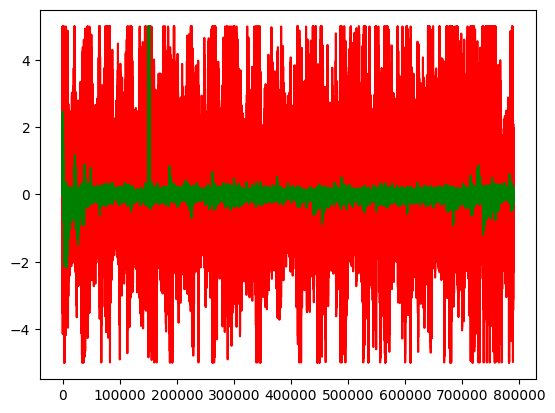

In [12]:
plt.plot(np.array(y_val).flatten(), color = 'red')
plt.plot(y_pred, color = 'green')

### Variant 2.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, RobustScaler
import torch.nn.functional as F

In [35]:
class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob=0.3):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(negative_slope=0.01),

            nn.Linear(hidden_dim // 2, 1)  # Ensure the final layer outputs 1 value per sample
        )

    def forward(self, x):
        return self.model(x)


class ClusterBasedNNRegression:
    def __init__(self, num_clusters, input_dim, hidden_dim, learning_rate=1e-3):
        self.num_clusters = num_clusters
        self.models = [RegressionNN(input_dim, hidden_dim) for _ in range(num_clusters)]
        self.optimizers = [optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) for model in self.models]
        self.criterions = [nn.MSELoss() for _ in range(num_clusters)]
        self.scaler = RobustScaler()  # Initialize scaler

    def fit(self, X, y, clusters, epochs=50, batch_size=32):
        # Масштабируем данные
        X = self.scaler.fit_transform(X)  # Fit scaler to training data

        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(X_cluster) == 0:
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue
            # Преобразование в numpy, если это DataFrame
            if isinstance(X_cluster, pd.DataFrame):
                X_cluster = X_cluster.values
            if isinstance(y_cluster, pd.DataFrame):
                y_cluster = y_cluster.to_numpy()
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
            y_tensor = torch.tensor(y_cluster, dtype=torch.float32).view(-1, 1)

            model = self.models[cluster]
            optimizer = self.optimizers[cluster]
            criterion = self.criterions[cluster]

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                output = model(X_tensor)
                loss = criterion(output, y_tensor)
                loss.backward()
                optimizer.step()

                if (epoch + 1) % 10 == 0:
                    print(f"Cluster {cluster}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    def predict(self, X, clusters):
        # Use the same scaler that was fitted during training
        X = self.scaler.transform(X)  # Transform validation data with the trained scaler
    
        y_pred = torch.zeros(X.shape[0])
    
        for cluster in range(self.num_clusters):
            # Convert cluster_indices to a PyTorch tensor
            cluster_indices = torch.tensor(clusters == cluster, dtype=torch.bool)
    
            if torch.sum(cluster_indices) == 0:
                print(f"Cluster {cluster} has no samples. Skipping prediction.")
                continue
    
            X_cluster = X[cluster_indices]
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
    
            model = self.models[cluster]
            model.eval()
    
            with torch.no_grad():
                y_pred[cluster_indices] = model(X_tensor).flatten()
    
        return y_pred.numpy()



In [36]:
# Параметры
input_dim = X_train.shape[1]  # Количество признаков

# Создаем модель
cluster_model = ClusterBasedNNRegression(num_clusters=num_clusters, input_dim=input_dim, hidden_dim=32)

# Обучаем модель
cluster_model.fit(X_train, y_train, clusters_train, epochs=10, batch_size=64)

# Предсказываем значения
y_pred = cluster_model.predict(X_val, clusters_test)


Cluster 0, Epoch [10/10], Loss: 0.5217
Cluster 1, Epoch [10/10], Loss: 1.4309
Cluster 2, Epoch [10/10], Loss: 0.4864


In [ ]:
mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weghts_val).flatten())
print(f"Mean Squared Error: {mse}")
print(f"r2: {r2}")
#  - np.median(y_pred)

### Допустим, метки кластеров содержатся в фиче "feature_10"
Обучим и сохраним такую модель

In [10]:
class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob=0.3):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(negative_slope=0.01),

            nn.Linear(hidden_dim // 2, 1)  # Ensure the final layer outputs 1 value per sample
        )

    def forward(self, x):
        return self.model(x)


class ClusterBasedNNRegression:
    def __init__(self, num_clusters, input_dim, hidden_dim, learning_rate=1e-3):
        self.num_clusters = num_clusters
        self.models = [RegressionNN(input_dim, hidden_dim) for _ in range(num_clusters)]
        self.optimizers = [optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) for model in self.models]
        self.criterions = [nn.MSELoss() for _ in range(num_clusters)]
        self.scaler = RobustScaler()  # Initialize scaler

    def fit(self, X, y, clusters, epochs=50, batch_size=32):
        # Масштабируем данные
        X = self.scaler.fit_transform(X)  # Fit scaler 

        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(X_cluster) == 0:
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue

            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
            y_tensor = torch.tensor(y_cluster, dtype=torch.float32).view(-1, 1)

            model = self.models[cluster]
            optimizer = self.optimizers[cluster]
            criterion = self.criterions[cluster]

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                output = model(X_tensor)
                loss = criterion(output, y_tensor)
                loss.backward()
                optimizer.step()

                if (epoch + 1) % 10 == 0:
                    print(f"Cluster {cluster}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    def predict(self, X, clusters):
        # Use the same scaler that was fitted during training
        X = self.scaler.transform(X)  # Transform validation data with the trained scaler
    
        y_pred = torch.zeros(X.shape[0])
    
        for cluster in range(self.num_clusters):
            # Convert cluster_indices to a PyTorch tensor
            cluster_indices = torch.tensor(clusters == cluster, dtype=torch.bool)
    
            if torch.sum(cluster_indices) == 0:
                print(f"Cluster {cluster} has no samples. Skipping prediction.")
                continue
    
            X_cluster = X[cluster_indices]
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
    
            model = self.models[cluster]
            model.eval()
    
            with torch.no_grad():
                y_pred[cluster_indices] = model(X_tensor).flatten()
    
        return y_pred.numpy()

    # Метод для сохранения модели
    def save_model(self, filepath):
        for i, model in enumerate(self.models):
            model_path = f"{filepath}_cluster_{i}.pth"
            torch.save(model.state_dict(), model_path)
        # Сохранить скейлер
        joblib.dump(self.scaler, f'{filepath}_scaler.pkl')
        print(f"Models and scaler saved to {filepath}")

In [11]:
# Допустим, метки кластеров содержатся в фиче "feature_10"
clusters_train = X_train["feature_10"].values
clusters_test = X_val["feature_10"].values

unique_clusters = np.unique(clusters_train)
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

clusters_train = np.array([cluster_mapping[c] for c in clusters_train])
clusters_test = np.array([cluster_mapping[c] for c in clusters_test])

# Удаляем feature_10 из данных, чтобы она не дублировалась
X_train = X_train.drop(columns=["feature_10"])
X_val = X_val.drop(columns=["feature_10"])


In [12]:
# Обучения на основе feature_10 as cluster
input_dim = X_train.shape[1]  # Количество признаков в данных
hidden_dim = 64  # Размер скрытого слоя
num_clusters = len(unique_clusters)  # Количество уникальных кластеров

# Создаем модель
cluster_model = ClusterBasedNNRegression(
    num_clusters=num_clusters,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    learning_rate=1e-3
)

# Преобразуем данные в массивы (если X_train и X_val – DataFrame)
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values



In [13]:
# Обучение модели
cluster_model.fit(X_train, y_train, clusters_train, epochs=10, batch_size=32)
cluster_model.save_model("cluster_based_model")

# Предсказание
y_pred = cluster_model.predict(X_val, clusters_test)

Cluster 0, Epoch [10/10], Loss: 0.6753
Cluster 1, Epoch [10/10], Loss: 0.7768
Cluster 2, Epoch [10/10], Loss: 0.5766
Cluster 3, Epoch [10/10], Loss: 0.8882
Cluster 4, Epoch [10/10], Loss: 0.4996
Cluster 5, Epoch [10/10], Loss: 0.4983
Cluster 6, Epoch [10/10], Loss: 0.6108
Cluster 7, Epoch [10/10], Loss: 0.7340
Cluster 8, Epoch [10/10], Loss: 0.6784
Models and scaler saved to cluster_based_model


In [14]:
mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weghts_val).flatten())
print(f"Mean Squared Error: {mse}")
print(f"r2: {r2}")
#  - np.median(y_pred)

Mean Squared Error: 0.5616039633750916
r2: -0.012543082237243652


standart scaler

Mean Squared Error: 0.5587099194526672
r2: -0.007509946823120117

robust scaler

Mean Squared Error: 0.5567154884338379
r2: -0.002652764320373535

robust + batch = 64. epoch =10

r2: -0,0004



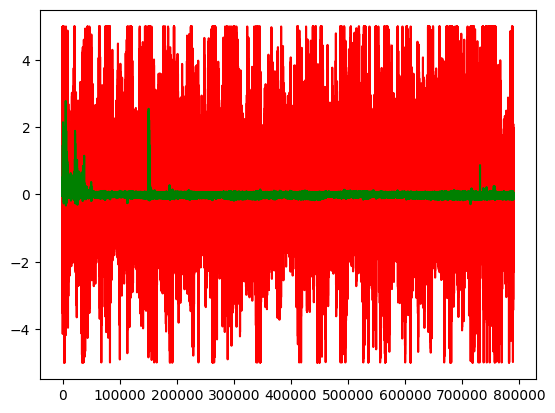

In [26]:
plt.plot(np.array(y_val).flatten(), color = 'red')
plt.plot(y_pred, color = 'green')

### Variant 3 not done
Variational Neural Network:

Нейронная сеть с одним скрытым слоем.

ClusterBasedVIRegression:
Создаёт по одной модели, гайду и оптимизатору для каждого кластера.
Использует pyro.infer.SVI для оптимизации с Trace_ELBO.

Метод fit: Кластеризует данные. Оптимизирует каждую модель для точек, принадлежащих соответствующему кластеру.

there is code for variational inference because it was based on work (https://www.sciencedirect.com/science/article/pii/S2405918824000151) https://doi.org/10.1016/j.jfds.2024.100130

In [50]:
# import torch
# import torch.nn as nn
# import pyro
# from pyro.infer import SVI, Trace_ELBO
# from pyro.optim import Adam
# from sklearn.cluster import KMeans
# import numpy as np


# class VariationalNeuralNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super(VariationalNeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, 1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         return self.fc2(x)


# class ClusterBasedVIRegression:
#     def __init__(self, num_clusters, input_dim, hidden_dim=64):
#         self.num_clusters = num_clusters
#         self.kmeans = KMeans(n_clusters=num_clusters)
#         self.models = []
#         self.guides = []
#         self.optimizers = []
#         self.svi = []
#         self.hidden_dim = hidden_dim
#         self.input_dim = input_dim

#         for _ in range(num_clusters):
#             model = VariationalNeuralNetwork(input_dim, hidden_dim)
#             self.models.append(model)
#             self.optimizers.append(Adam({"lr": 1e-3}))
#             self.svi.append(SVI(model=self._create_model(model), guide=self._create_guide(model), optim=self.optimizers[-1], loss=Trace_ELBO()))

#     def _create_model(self, model):
#         def model_fn(x, y=None):
#             with pyro.plate("data", size=x.shape[0]):
#                 weight_prior = pyro.distributions.Normal(0, 1).expand(model.fc1.weight.shape).to_event(2)
#                 bias_prior = pyro.distributions.Normal(0, 1).expand(model.fc1.bias.shape).to_event(1)
#                 priors = {"fc1.weight": weight_prior, "fc1.bias": bias_prior}

#                 lifted_module = pyro.random_module("module", model, priors)
#                 lifted_model = lifted_module()
#                 predictions = lifted_model(x).squeeze()

#                 if y is not None:
#                     pyro.sample("obs", pyro.distributions.Normal(predictions, 1), obs=y)

#         return model_fn

#     def _create_guide(self, model):
#         def guide_fn(x, y=None):
#             # Создаём новый экземпляр модели в guide_fn
#             model_instance = VariationalNeuralNetwork(self.input_dim, self.hidden_dim)
            
#             softplus = torch.nn.Softplus()

#             weight_loc = torch.randn_like(model_instance.fc1.weight)
#             weight_scale = softplus(torch.randn_like(model_instance.fc1.weight))
#             bias_loc = torch.randn_like(model_instance.fc1.bias)
#             bias_scale = softplus(torch.randn_like(model_instance.fc1.bias))

#             weight_dist = pyro.distributions.Normal(weight_loc, weight_scale).to_event(2)
#             bias_dist = pyro.distributions.Normal(bias_loc, bias_scale).to_event(1)

#             priors = {"fc1.weight": weight_dist, "fc1.bias": bias_dist}
#             pyro.module("module", model_instance)
#             pyro.sample("module", pyro.random_module("module", model_instance, priors))

#         return guide_fn

#     def fit(self, X, y, epochs=100):
#         X = X.values
#         y = y.values
#         clusters = self.kmeans.fit_predict(X)
#         for epoch in range(epochs):
#             for cluster in range(self.num_clusters):
#                 cluster_indices = clusters == cluster
#                 if np.any(cluster_indices):
#                     x_cluster = torch.tensor(X[cluster_indices], dtype=torch.float32)
#                     y_cluster = torch.tensor(y[cluster_indices], dtype=torch.float32)

#                     loss = self.svi[cluster].step(x_cluster, y_cluster)
#             print(f"Epoch {epoch + 1}, Loss: {loss}")

#     def predict(self, X, clusters):
#         y_pred = np.zeros(X.shape[0])
#         for cluster in range(self.num_clusters):
#             cluster_indices = clusters == cluster
#             if np.any(cluster_indices):
#                 x_cluster = torch.tensor(X[cluster_indices], dtype=torch.float32)
#                 predictions = self.models[cluster](x_cluster).detach().numpy()
#                 y_pred[cluster_indices] = predictions.ravel()
#         return y_pred

In [51]:
# model = ClusterBasedVIRegression(num_clusters=3, input_dim=X_train.shape[1], hidden_dim=64)
# model.fit(X_train, y_train, epochs=50)

# # Прогнозирование
# clusters_test = model.kmeans.predict(X_val)
# y_pred = model.predict(X_val, clusters_test)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyro/poutine/lift_messenger.py:74: UserWarning: pyro.module prior did not find params ['fc1.bias']. Did you instead mean one of ['']?
  warnings.warn(


RuntimeError: module$$$fc1.weight is already in the trace as a param
      Trace Shapes:      
       Param Sites:      
module$$$fc1.weight 64 81
  module$$$fc1.bias    64
module$$$fc2.weight  1 64
  module$$$fc2.bias     1
      Sample Sites:      

In [ ]:
# # Оценка качества
# from sklearn.metrics import mean_squared_error

# mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
# print(f"Mean Squared Error: {mse}")

# r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weghts_val).flatten())
# print(f"r2: {r2}")

In [ ]:
# plt.plot(np.array(y_val).flatten(), color = 'red')
# plt.plot(y_pred, color = 'green')